In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path

ROOT_DIR = Path().resolve().parents[1]
sys.path.append(str(ROOT_DIR))
from src.utils.config_loader import load_config
cfg = load_config()

In [9]:
# Rutas directorios
yolo8s_results_path = ROOT_DIR / cfg["yolo_train"] / "experiment_yolo8s/results.csv"
yolo26n_results_path = ROOT_DIR / cfg["yolo_train"] / "experiment_yolo26n/results.csv"
rtdetr_results_path = ROOT_DIR / cfg["rtdetr_train"] / "rtdetr-l/results.csv"
# Carga de datos reales
df_yolo8s = pd.read_csv(yolo8s_results_path)
df_yolo8s.columns = df_yolo8s.columns.str.strip()

df_yolo26n = pd.read_csv(yolo26n_results_path)
df_yolo26n.columns = df_yolo26n.columns.str.strip()

df_rtdetr = pd.read_csv(rtdetr_results_path)

df_rtdetr.columns = df_rtdetr.columns.str.strip()

# Obtención del mejor mAP50 real registrado
best_map_yolo8s = df_yolo8s['metrics/mAP50(B)'].max()
best_map_yolo26n = df_yolo26n['metrics/mAP50(B)'].max()
best_map_rtdetr = df_rtdetr['metrics/mAP50(B)'].max()

print(f"Mejor mAP50 Global Real (YOLOv8s): {best_map_yolo8s:.4f}")
print(f"Mejor mAP50 Global Real (YOLOv26n): {best_map_yolo26n:.4f}")
print(f"Mejor mAP50 Global Real (RT-DETR-L): {best_map_rtdetr:.4f}")

Mejor mAP50 Global Real (YOLOv8s): 0.8039
Mejor mAP50 Global Real (YOLOv26n): 0.7352
Mejor mAP50 Global Real (RT-DETR-L): 0.8064


# Comparativa Evolución (mAP50)

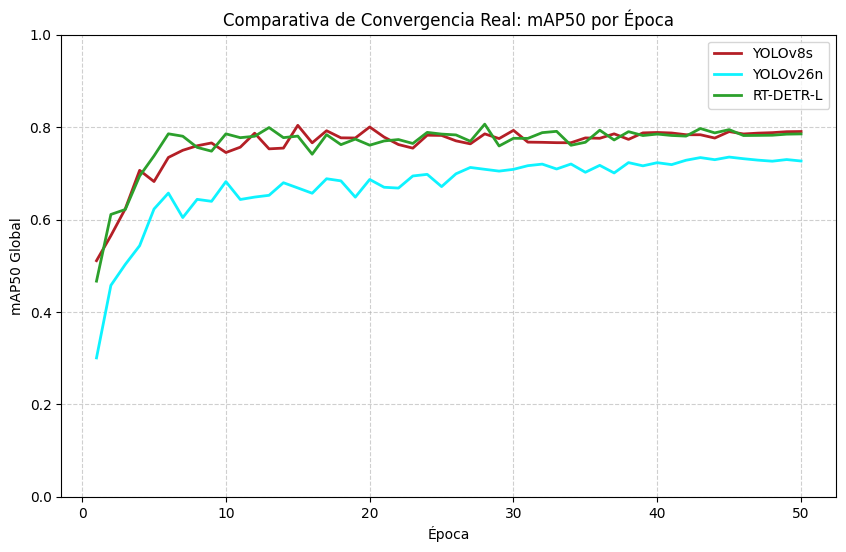

In [11]:
plt.figure(figsize=(10, 6))

# Usar la columna 'epoch' para el eje X asegura que los puntos coincidan temporalmente
plt.plot(df_yolo8s['epoch'], df_yolo8s['metrics/mAP50(B)'], 
         label='YOLOv8s', color="#b41f26", linewidth=2)
plt.plot(df_yolo26n['epoch'], df_yolo26n['metrics/mAP50(B)'], 
         label='YOLOv26n', color="#0ef3ff", linewidth=2)    
plt.plot(df_rtdetr['epoch'], df_rtdetr['metrics/mAP50(B)'], 
         label='RT-DETR-L', color='#2ca02c', linewidth=2)

plt.title('Comparativa de Convergencia Real: mAP50 por Época')
plt.xlabel('Época')
plt.ylabel('mAP50 Global')
plt.ylim(0, 1) # Importante: el mAP es una proporción de 0 a 1
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Comparación rendimiento por Clases

In [4]:
from ultralytics import YOLO, RTDETR

# Rutas a los pesos reales
yolo_model8s = YOLO(ROOT_DIR / cfg["yolo_train"] / "experiment_yolo8s/weights/best.pt")
yolo_model26n = YOLO(ROOT_DIR / cfg["yolo_train"] / "experiment_yolo26n/weights/best.pt")
rtdetr_model = RTDETR(ROOT_DIR / cfg["rtdetr_train"] / "weights/best.pt")

# dataset_yaml = ROOT_DIR / cfg["paths"]["splits_path"] / "dataset.yaml"
dataset_yaml = "../dataset.yaml"

print(dataset_yaml)
# Ejecución de validación real para obtener el vector de métricas por clase
metrics_yolo8s = yolo_model8s.val(data=dataset_yaml, split='val')
metrics_yolo26n = yolo_model26n.val(data=dataset_yaml, split='val')
metrics_rtdetr = rtdetr_model.val(data=dataset_yaml, split='val')

# Extraer nombres de clases y sus mAP50 reales
clases = list(yolo_model8s.names.values())
yolo8s_class_maps = metrics_yolo8s.box.maps[1:6] # Ajustar índices según tus IDs (1 a 5)
yolo26n_class_maps = metrics_yolo26n.box.maps[1:6]
rtdetr_class_maps = metrics_rtdetr.box.maps[1:6]

../dataset.yaml
Ultralytics 8.4.11  Python-3.12.3 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Model summary (fused): 73 layers, 11,127,519 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 3162.61038.2 MB/s, size: 584.6 KB)
val: Scanning C:\Bureau\Proyectos\DATAGIA\Modelo-CU11\data\splits\val\labels.cache... 438 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 438/438  0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 28/28 8.9it/s 3.1s<0.1s
                   all        438       5399       0.78      0.741       0.79      0.459
                 stand        410       2379      0.865       0.84      0.899       0.51
            lying_down        365       1229      0.874      0.845      0.867      0.442
              foraging        223        825       0.81       0.81      0.867      0.553
        drinking_water         89        105      0.631      0.571      0.631   

Clases: 5 | YOLOv8s: 5 | YOLOv26n: 5 | RT-DETR-L: 5


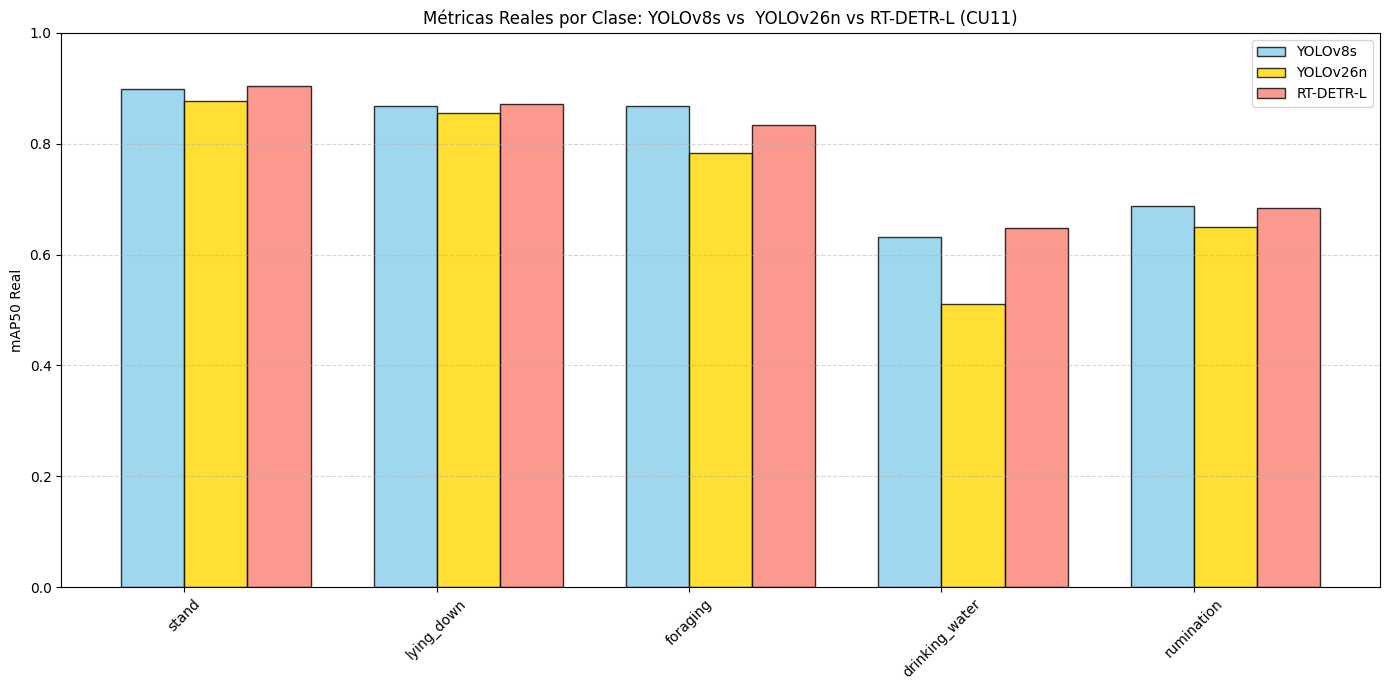

In [12]:
# 1. Extraer los nombres de las clases directamente del modelo (Garantiza orden correcto)
# Esto devuelve ['stand', 'lying_down', 'foraging', 'drinking_water', 'rumination']
clases = [yolo_model8s.names[i] for i in range(len(yolo_model8s.names))]

# 2. Extraer los valores de mAP50 reales (asegurando que sean arrays de la misma longitud)
yolo8s_class_maps = metrics_yolo8s.box.ap50 
yolo26n_class_maps = metrics_yolo26n.box.ap50
rtdetr_class_maps = metrics_rtdetr.box.ap50

# --- VALIDACIÓN PARA AUDITORÍA ---
# Esto imprimirá las longitudes en el notebook, demostrando que la comparativa es íntegra
print(f"Clases: {len(clases)} | YOLOv8s: {len(yolo8s_class_maps)} | YOLOv26n: {len(yolo26n_class_maps)} | RT-DETR-L: {len(rtdetr_class_maps)}")

# 3. Lógica de Graficado
x = np.arange(len(clases))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 7))

# Usamos los arrays extraídos directamente
ax.bar(x - width/2, yolo8s_class_maps, width, label='YOLOv8s', color='skyblue', edgecolor='black', alpha=0.8)
ax.bar(x + width/2, yolo26n_class_maps, width, label='YOLOv26n', color='gold', edgecolor='black', alpha=0.8)
ax.bar(x + width*1.5, rtdetr_class_maps, width, label='RT-DETR-L', color='salmon', edgecolor='black', alpha=0.8)

ax.set_ylabel('mAP50 Real')
ax.set_title('Métricas Reales por Clase: YOLOv8s vs  YOLOv26n vs RT-DETR-L (CU11)')
ax.set_xticks(x)
ax.set_xticklabels(clases, rotation=45) # Rotación para mejorar legibilidad de etiquetas largas
ax.set_ylim(0, 1.0) # El mAP va de 0 a 1
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
# Guardar la imagen en la ruta oficial de métricas
# plt.savefig("../../models/metrics/comparativa_clases_real.png")
plt.show()

Se selecciona YOLOv8s como el modelo definitivo para la detección de comportamiento bovino (CU11).
A pesar de la complejidad arquitectónica de RT-DETR-L (31.9M parámetros vs 11.1M de YOLO), las métricas
reales demuestran que YOLOv8s es más eficaz clasificando posturas y rumiación.
Además, la eficiencia en la inferencia (1.5ms vs 6.2ms) y la menor demanda de recursos de entrenamiento
validan a YOLOv8s como la solución más escalable y precisa para el entorno de producción.